In [8]:
import math
import numpy as np
import pandas as pd
import torch

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

from openhsl.base.hsi import HSImage
from openhsl.base.hs_mask import HSMask, convert_to_color
from openhsl.nn.data.utils import apply_pca, HyperStandardScaler 
from openhsl.nn.models.m1dcnn import M1DCNN
from openhsl.nn.models.ssftt import SSFTT
from openhsl.nn.models.utils import draw_fit_plots, get_accuracy, get_f1

### Загрузим тестовый набор данных

In [9]:
hsi = HSImage()
mask = HSMask()

hsi.load('./test_data/tr_pr/PaviaU.mat', key='paviaU')
mask.load('./test_data/tr_pr/PaviaU_gt.mat', key='paviaU_gt')

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!


### Для нормализации данных воспользуемся скалером HyperStandardScaler из openhsl.nn.data.utils

In [10]:
scaler = HyperStandardScaler()

In [11]:
hsi.data = scaler.fit_transform(hsi.data)

### Для уменьшения количества каналов воспользуемся методом главных компонент apply_pca из openhsl.nn.data.utils

In [12]:
hsi_pca, pca = apply_pca(hsi.data, num_components=30)

Will apply PCA from 103 to 30


### Зададим параметры обучения

In [14]:
optimizer_params = {
    "learning_rate": 0.1,
    "weight_decay": 0
}

scheduler_params = {
    "step_size": 5,
    "gamma": 0.5
}

fit_params = {
    "epochs": 20,
    "train_sample_percentage": 0.1,
    "dataloader_mode": "fixed",
    "optimizer_params": optimizer_params,
    "batch_size": 128,
    "scheduler_type": 'StepLR',
    "scheduler_params": scheduler_params
}

### Создадим объект нейросетевого классификатора

Требуется указывать количество классов (n_classes), которые будут предсказываться и количество спектральных каналов (n_bands).

Для загрузки весов предобученной модели требуется указать путь до них в параметре path_to_weights

Список доступных моделей из пакета openhsl.models
- m1dcnn.M1DCNN
- m3dcnn_li.M3DCNN
- nm3dcnn.NM3DCNN
- tf2dcnn.TF2DCNN
- ssftt.SSFTT

In [15]:
cnn = M1DCNN(n_classes=mask.n_classes,
             n_bands=hsi_pca.shape[-1],
             #path_to_weights='path_to_checkpoint...',
             device='cuda')

### Обучение классификатора производится вызовом встроенного метода fit

In [16]:
cnn.fit(X=hsi_pca,
        y=mask,
        fit_params=fit_params)

Sampling fixed with train size = 0.1 for train_val/test
Sampling fixed with train size = 0.9 for train/val
Full size: 42776
Train size: 3841
Val size: 432


Train loop: 100%|█| 20/20 [00:14<00:00,  1.38it/s, train_acc=0.904, val_acc=0.864, train_loss=0.296, val_loss=0.373, lr


### Отрисуем графики обучения

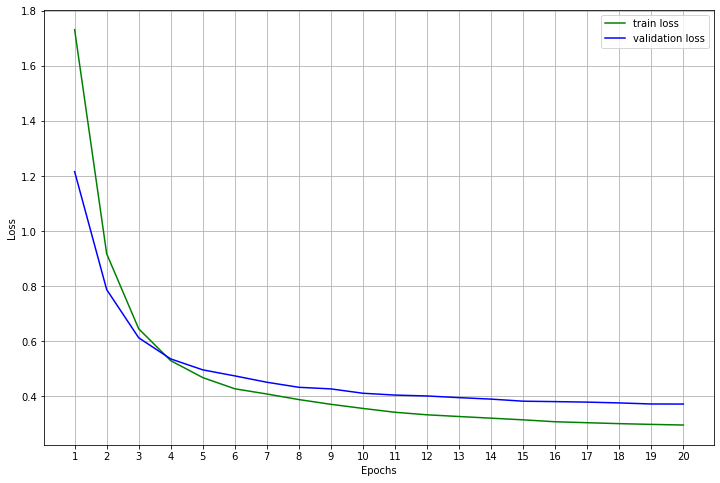

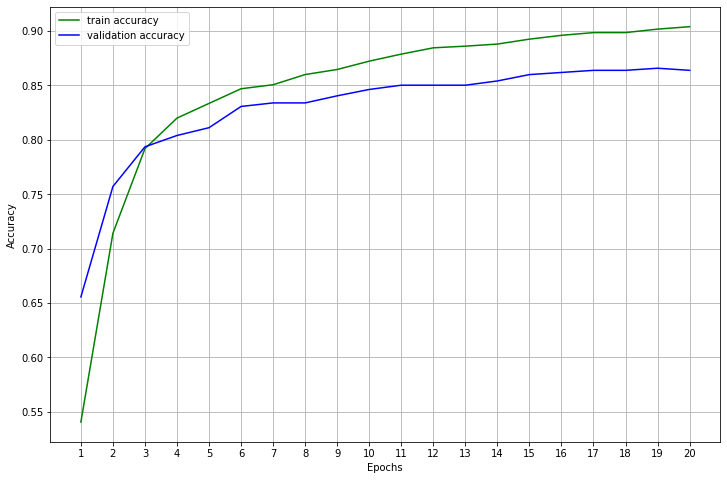

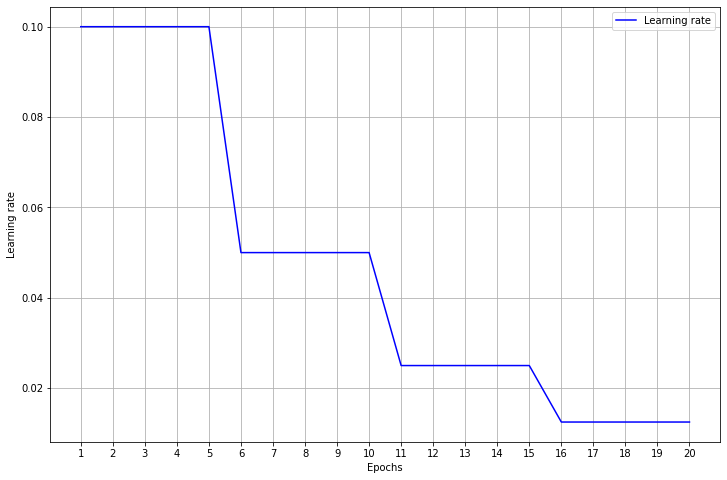

In [17]:
draw_fit_plots(model=cnn)

### Инференс классификатора производится вызовом встроенного метода predict

In [18]:
pred = cnn.predict(X=hsi_pca)

# Отобразим только размеченные области
pred = pred * (mask.get_2d() > 0)

Inference on the image: 1621it [00:02, 744.60it/s]                                                                     


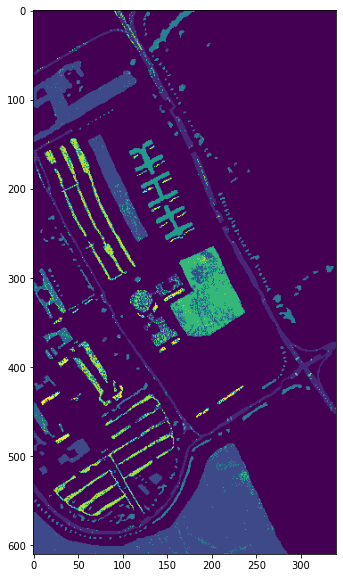

In [19]:
# Отрисуем результат инференса
plt.figure(figsize=(10,10))
plt.imshow(pred)
plt.show()

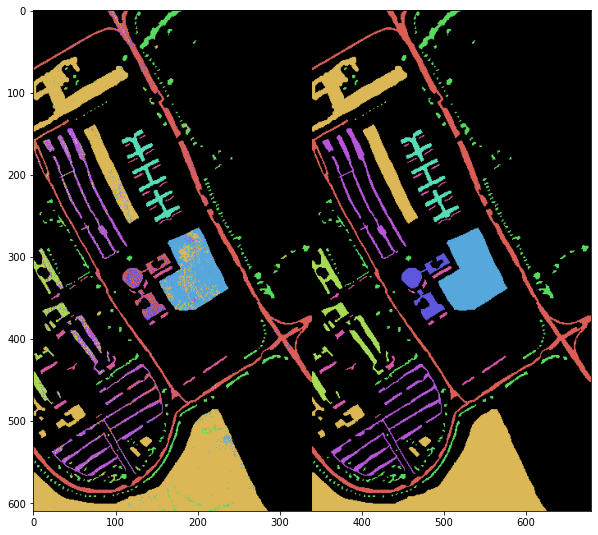

In [20]:
# Для большей наглядности раскрасим маски и отрисуем результат инференса (слева) вместе с эталоном (справа)

color_pred = convert_to_color(pred)

plt.figure(figsize=(10,10))
plt.imshow(np.hstack((color_pred, convert_to_color(mask.get_2d()))))
plt.show()

In [21]:
# Получим метрики классификации
accuracy = get_accuracy(pred, mask)
f1 = get_f1(pred, mask, average='weighted')

In [22]:
print(f'acc: {accuracy}')
print(f'f1 weighted: {f1}')

acc: 0.8866420422666916
f1 weighted: 0.8829944673233298
